In [1]:
# plotting libraries
import matplotlib
import matplotlib.pyplot as plt 
# numpy (math) libary
import numpy as np

from os import walk

path1 = '../../../data/'

# torch library and sublibraries
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
f = [] # empty list of files
for (dirpath, dirnames, filenames) in walk(path1):
    f.extend(filenames)

# sort list alphabetically
f.sort()
# remove non .tsv files from list
f = [x for x in f if x[-4:]==".ssv"]

In [3]:
# get length of filename list
f_len = len(f)

# exclude/add file section
for ii in range(f_len):
    print(ii, f[ii])

0 full_speach_data.ssv


In [4]:
data = {} # empty data dictionary

for ff in range(f_len):
    temp = np.loadtxt(path1+f[ff])
    data['x'] = np.copy(temp)[:,3:-1]
    y = np.zeros((temp.shape[0], 11))
    for jj in range(temp.shape[0]):
        y[jj, int(temp[jj,-1])] += 1
    data['y'] = np.copy(y)
    #del temp, x, y
    del y

print(data['x'].shape)
print(data['y'].shape)
print()

jj = 6
print(data['x'][jj,:])
print(data['y'][jj,:])
print(temp[jj,-1])

(990, 10)
(990, 11)

[-3.482  2.524 -0.433  1.048 -1.995  0.902  0.322  0.45   0.377 -0.366]
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
6.0


In [5]:
# normalize data
for jj in range(data['x'].shape[1]):
    data['x'][:,jj] = (data['x'][:,jj]-min(data['x'][:,jj]))/max(data['x'][:,jj])

In [6]:
# divide training and test sets
train = {}
test = {}

# The problem is to train the network as well as possible using only
# on data from "speakers" 0-47, and then to test the network on
# speakers 48-89, reporting the number of correct classifications
# in the test set.

# setting '0'
default = [48*11, 42*11]
# setting '1'
nondefault = [45*11, 45*11]

setting = 0
if setting == 0:
    train['x'] = np.copy(data['x'][:default[0],:])
    train['y'] = np.copy(data['y'][:default[0],:])
    
    test['x']  = np.copy(data['x'][-default[1]:,:])
    test['y']  = np.copy(data['y'][-default[1]:,:])
elif setting == 1:
    train['x'] = np.copy(data['x'][:nondefault[0],:])
    train['y'] = np.copy(data['y'][:nondefault[0],:])
    
    test['x']  = np.copy(data['x'][-nondefault[1]:,:])
    test['y']  = np.copy(data['y'][-nondefault[1]:,:])
    
print(train['x'].shape)
print(train['y'].shape)
print()
print(test['x'].shape)
print(test['y'].shape)

(528, 10)
(528, 11)

(462, 10)
(462, 11)


In [7]:
# define settings for plots
colors = (('xkcd:orange', 'xkcd:red'),#
          ('xkcd:blue', 'xkcd:purple'),#
          ('xkcd:green', 'xkcd:lime'),#
         )

def show_graph(string):
    fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
    ax1 = fig.add_subplot(111)

    if string=='loglog':
        for ii, ee in err.items():
            ax1.loglog(ee[2][:], label='error %s, lr=%1.0e'%(ee[0],ee[1]))
    elif string=='logy':
        for ii, ee in err.items():
            ax1.semilogy(ee[2][:], label='error %s, lr=%1.0e'%(ee[0],ee[1]))
    elif string=='logx':
        for ii, ee in err.items():
            ax1.semilogy(ee[2][:], label='error %s, lr=%1.0e'%(ee[0],ee[1]))
    else:
        for ii, ee in err.items():
            ax1.plot(ee[2][:], label='error %s, lr=%1.0e'%(ee[0],ee[1]))

    ax1.set_xlabel('iteration number', fontsize = 16)
    ax1.set_ylabel('loss', fontsize = 16)
    title_string = '%d epochs, batch size %d; [%d, %d, %d] are input, hidden, and output dimensions'%(epochs,N,D_in,H,D_out)
    ax1.set_title(title_string, fontsize = 16)
    legend = ax1.legend(loc='best', fontsize=16)

    plt.show()
    plt.close()

show_type = 'logy' # prints errors in semi-log axis

In [8]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N     = train['x'].shape[0]
D_in  = train['x'].shape[1]
H     = 64
D_out = train['y'].shape[1]

epochs = int(2e3)

In [9]:
# model settings
base_lr = 1e-4
sigm_lr = 1e-6
best_lr = 1.5e-5

# (re-)initialize data dictionary
#mdl = [] # as in model
err = {} # as in error

In [10]:
# create x & y tensors
x = Variable( torch.from_numpy(train['x']).float() )
y = Variable( torch.from_numpy(train['y']).float() )
# either input data is float or model becomes doublefloat
# https://stackoverflow.com/questions/44717100/pytorch-convert-floattensor-into-doubletensor?rq=1

In [11]:
# define baseline network with relu (clamp)
class Baseline(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(Baseline, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linearOut = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        # sum (linear1) and then relu (clamp)
        h1     = self.linear1(x).clamp(min=0)
        # sum (linear2) and then relu (clamp)
        h2     = self.linear2(h1).clamp(min=0)
        # sum (out) and the output
        y_pred = self.linearOut(h2)
        return y_pred # output = y_pred(icted)

# Construct our model by instantiating the class defined above
basemodel = Baseline(D_in, H, D_out)

# initialize dictionary item
err[0] = ('relu',base_lr,[])

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(basemodel.parameters(), lr=err[0][1])

for t in range(epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = basemodel(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    err[0][2].append(loss.data[0])
    if (t+1)%(epochs//20) == 0:
        print(t+1, loss.data[0])

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
del criterion, optimizer

100 404.17559814453125
200 376.886474609375
300 356.53424072265625
400 341.521728515625
500 324.8274230957031
600 310.1773986816406
700 293.9029235839844
800 280.6551513671875
900 270.31304931640625
1000 255.44039916992188
1100 247.80491638183594
1200 231.4837646484375
1300 220.7672119140625
1400 210.47096252441406
1500 200.72047424316406
1600 201.04278564453125
1700 189.21542358398438
1800 178.5076904296875
1900 170.36935424804688
2000 158.04244995117188


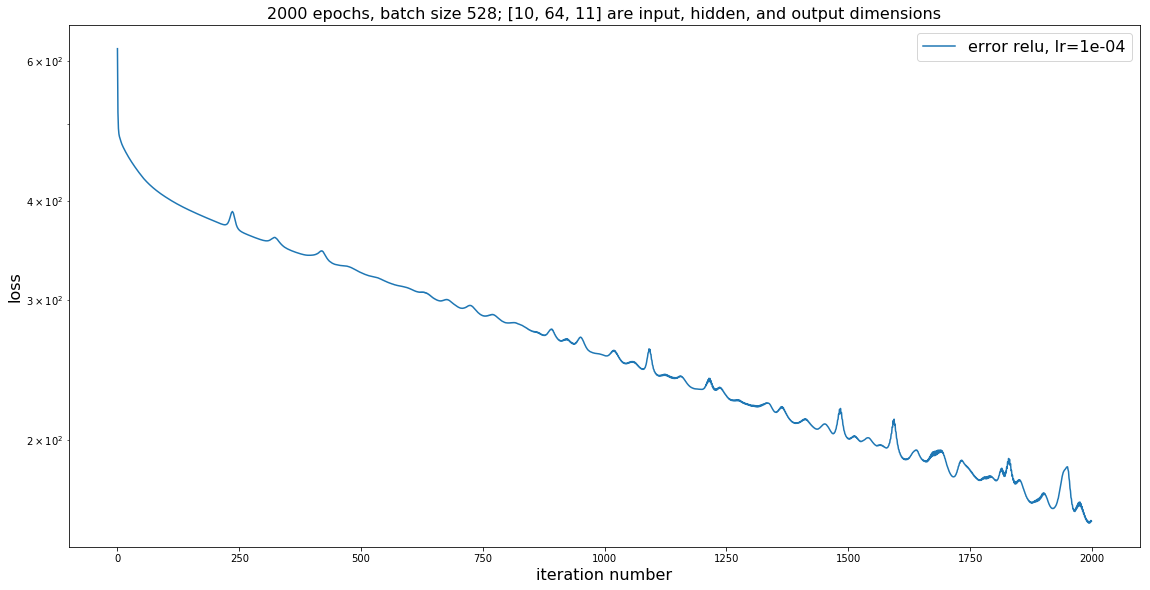

In [12]:
show_graph(show_type)

In [13]:
# define different network with sigmoid
class BaseSigmoid(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(BaseSigmoid, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linearOut = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        # sum (linear1) and then sigmoid (F.sigmoid)
        h1     = F.sigmoid(self.linear1(x))
        # sum (linear2) and then sigmoid (F.sigmoid)
        h2     = F.sigmoid(self.linear2(h1))
        # sum (out) and the output
        y_pred = self.linearOut(h2)
        return y_pred # output = y_pred(icted)

# Construct our model by instantiating the class defined above
sigmodel = BaseSigmoid(D_in, H, D_out)

# initialize dictionary item
err[1] = ('sigmoid',sigm_lr,[])

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(sigmodel.parameters(), lr=err[1][1])

for t in range(epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = sigmodel(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    err[1][2].append(loss.data[0])
    if (t+1)%(epochs//20) == 0:
        print(t+1, loss.data[0])

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
del criterion, optimizer

100 513.871337890625
200 481.7943115234375
300 480.8345031738281
400 480.7658996582031
500 480.7219543457031
600 480.6790771484375
700 480.6366882324219
800 480.5950012207031
900 480.5527038574219
1000 480.5101623535156
1100 480.4681396484375
1200 480.4259948730469
1300 480.38372802734375
1400 480.3414001464844
1500 480.2991638183594
1600 480.257080078125
1700 480.2154846191406
1800 480.1734619140625
1900 480.1319580078125
2000 480.0899353027344


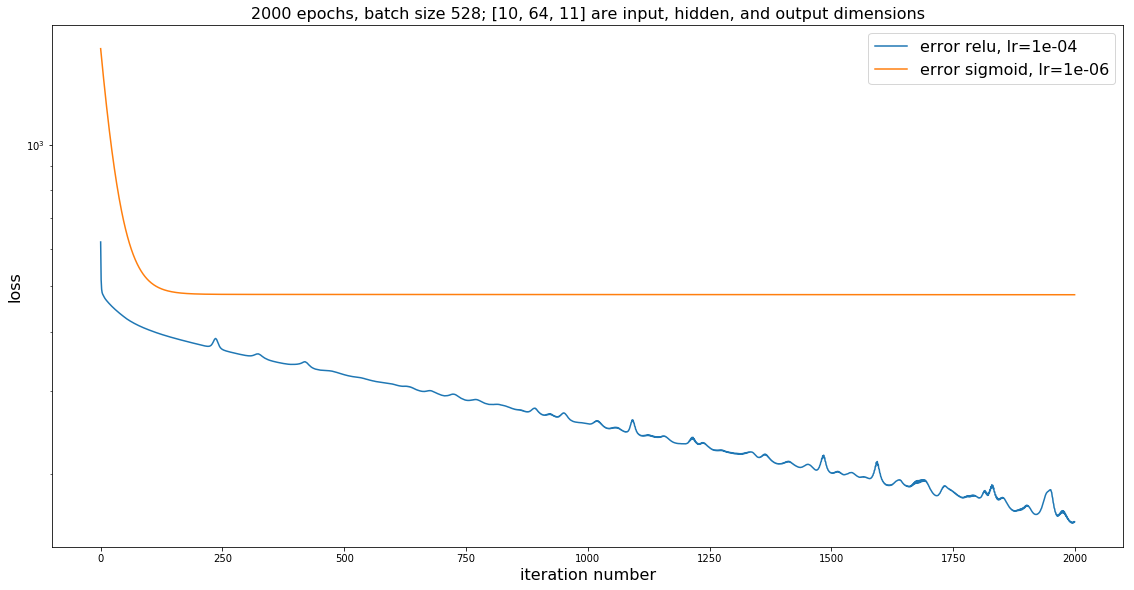

In [14]:
show_graph(show_type)

In [15]:
class BestSigmoid(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(BestSigmoid, self).__init__()
        self.linear1   = torch.nn.Linear(D_in, H)
        self.linear2   = torch.nn.Linear(H, H)
        self.linearOut = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        # parameters
        p = [ 689.651615, 0.433819208, 1.31042204, -0.975437185, -0.518489780, 0.403015568, 0.502495627]
        
        #p[0], p[1], p[2], p[3], p[4], p[5], p[6]
        #  a,    b,    c,    d,    g,   x0,   x1)
        #b*sigmoid(a*(arg-x0))+c*relu(arg)+d*relu(arg-x0)+g*relu(arg-x1)
        
        h1 = torch.mul( torch.sigmoid( self.linear1(x).add_(-p[5]).mul_(p[0]) ), p[1] )
        h1.add_( self.linear1(x).clamp(min=0).mul_(p[2]) )
        h1.add_( self.linear1(x).clamp(min=p[5]).mul_(p[3]) )
        h1.add_( self.linear1(x).clamp(min=p[6]).mul_(p[4]) )
        
        h2 = torch.mul( torch.sigmoid( self.linear2(h1).add_(-p[5]).mul_(p[0]) ), p[1] )
        h2.add_( self.linear2(h1).clamp(min=0).mul_(p[2]) )
        h2.add_( self.linear2(h1).clamp(min=p[5]).mul_(p[3]) )
        h2.add_( self.linear2(h1).clamp(min=p[6]).mul_(p[4]) )
        
        # sum (out) and the output
        y_pred = self.linearOut(h2)
                                
        return y_pred # output = y_pred(icted)

# Construct our model by instantiating the class defined above
bestmodel = BestSigmoid(D_in, H, D_out)

# initialize dictionary item
err[2] = ('bestfit',best_lr,[])

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(bestmodel.parameters(), lr=err[2][1])

for t in range(epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = bestmodel(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    err[2][2].append(loss.data[0])
    if (t+1)%(epochs//20) == 0:
        print(t+1, loss.data[0])

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
del criterion, optimizer

100 436.08526611328125
200 406.9806823730469
300 384.24664306640625
400 367.27154541015625
500 352.58782958984375
600 340.3627624511719
700 328.3739318847656
800 319.51080322265625
900 303.57373046875
1000 296.0478210449219
1100 283.0491027832031
1200 274.65313720703125
1300 269.2181091308594
1400 273.2037658691406
1500 250.18572998046875
1600 249.22531127929688
1700 238.9020233154297
1800 229.39964294433594
1900 231.6549530029297
2000 218.70462036132812


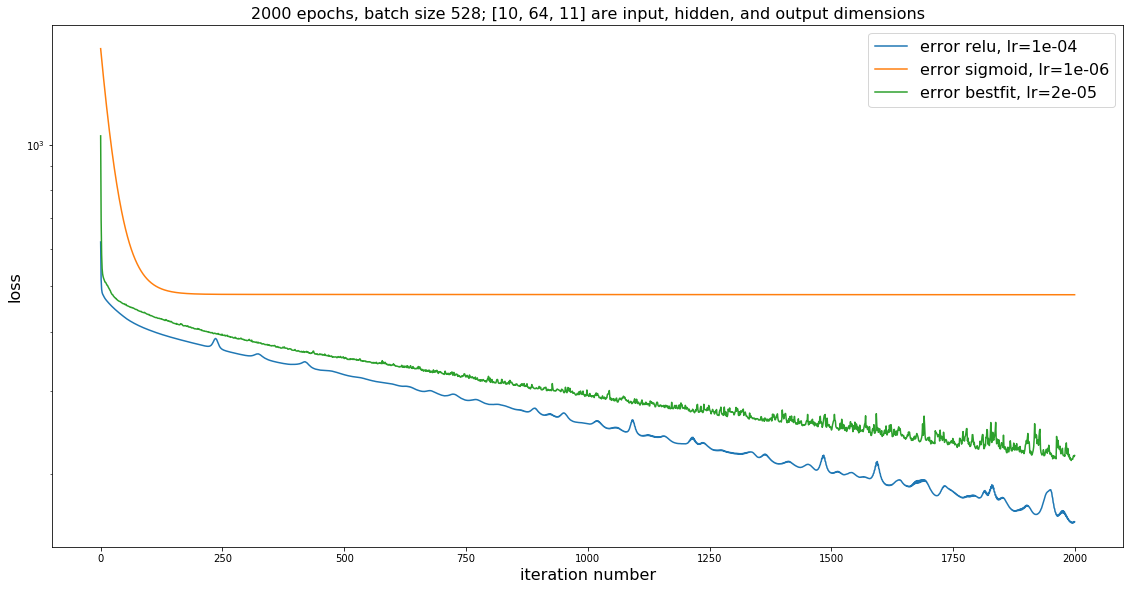

In [16]:
show_graph(show_type)